# Homework: Not So Basic Artificial Neural Networks

Your task is to implement a simple framework for convolutional neural networks training. While convolutional neural networks is a subject of lecture 3, we expect that there are a lot of students who are familiar with the topic.

In order to successfully pass this homework, you will have to:

- Implement all the blocks in `homework_modules.ipynb` (esp `Conv2d` and `MaxPool2d` layers). Good implementation should pass all the tests in `homework_test_modules.ipynb`.
- Settle with a bit of math in `homework_differentiation.ipynb`
- Train a CNN that has at least one `Conv2d` layer, `MaxPool2d` layer and `BatchNormalization` layer and achieves at least 97% accuracy on MNIST test set.

Feel free to use `homework_main-basic.ipynb` for debugging or as source of code snippets. 

Note, that this homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook with cnn trained
- `homework_modules.ipynb`
- `homework_differentiation.ipynb`

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [4]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()  # your dataset

In [5]:
# Your turn - train and evaluate conv neural network

In [6]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train_ohe = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_ohe = ohe.transform(y_val.reshape(-1, 1)).toarray()
y_test_ohe = ohe.transform(y_test.reshape(-1, 1)).toarray()

/home/iorana/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### 1 Set up the neural network

In [7]:
# Optimizer
config = {
    'learning_rate' : 1e-3,
    'beta1' : 0.99,
    'beta2' : 0.999,
    'epsilon' : 1e-8
}

In [8]:
net = Sequential()
# Stable negative likelihood criterion
criterion = ClassNLLCriterion()

net.add(Conv2d(1, 8, 3))
net.add(MaxPool2d(2))
net.add(Conv2d(8, 16, 3))
net.add(ReLU())
net.add(MaxPool2d(2))
net.add(Flatten())
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(128, 10))
net.add(LogSoftMax())

print(net)

Conv2d 1 -> 8
MaxPool2d, kern 2, stride 2
Conv2d 8 -> 16
ReLU
MaxPool2d, kern 2, stride 2
Flatten
Linear 784 -> 128
ReLU
Dropout
Linear 128 -> 10
LogSoftMax



Print here your accuracy on test set. It should be >97%. Don't forget to switch the network in 'evaluate' mode

In [9]:
loss_history = []
batch_size = 256
epochs = 3
net.train()
for epoch in range(epochs):
    print(f'We are now on epoch {epoch}')
    batches = get_batches((X_train, y_train_ohe), batch_size)
    k = 0
    for x_batch, y_batch in batches:
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        adam_optimizer(net.getParameters(),
                       net.getGradParameters(),
                       config,
                       {})
        
        loss_history.append(loss)

    # Performance on validation set
    net.evaluate()    
    predictions_val = net.forward(X_val)
    loss_val = criterion.forward(predictions_val, y_val_ohe)
    pred_val = predictions_val.argmax(axis=1)
    acc_val = np.mean(pred_val == y_val)
    print(f'Validation loss/accuracy after epoch {epoch}: {loss_val}/{acc_val}\n')
    net.train()

We are now on epoch 0
Validation loss/accuracy after epoch 0: 0.1437832923928155/0.9583

We are now on epoch 1
Validation loss/accuracy after epoch 1: 0.09132664687472106/0.9754

We are now on epoch 2
Validation loss/accuracy after epoch 2: 0.08339809499466144/0.9783



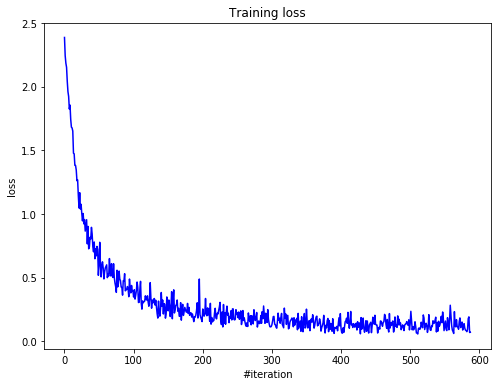

In [10]:
# Visualize
display.clear_output(wait=True)
plt.figure(figsize=(8, 6))

plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, 'b')
plt.show()

### 2 Accuracy on test

In [11]:
net.evaluate()
pred_test = net.forward(X_test).argmax(axis=1)
acc_test = np.mean(pred_test == y_test)

print(f'Accuracy reached on test data: {acc_test}')

Accuracy reached on test data: 0.9751
